<a href="https://colab.research.google.com/github/gleesonm1/EPS100B_Notebooks/blob/main/EPS100B_ExtraCredit1_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mantle melting and the link between magma chemistry, crustal thickness, and mantle potential tempereture

One key feature of mid-ocean ridge basalts that we have not discussed extensively in this course is that the chemistry of the erupted lavas is correlated with the thickness of the crust produced by melting in mid-ocean ridges. In fact, the plot below shows that as the depth to the ridge axis decreases (indicating thicker crust and thus more melting), the Na content of the erupted magmas (here the Na$_2$O content of the basalts at 8 wt% MgO) goes down.

![alt text](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcR24SagNdaLJDODeiExeCigPj0WBAonRwQSKhcgG88K8t3KY9ko)
  
This extra-credit homework is to try and get your to think about why. Before we start with any calculations, however, it'll be helpful to first read pages 1 - 5 of the following paper:
https://dash.harvard.edu/handle/1/3685824

With all Python code, we need to start our notebook by importing the important packages - typically numpy (data processing), pandas (data visualization and storage), matplotlib.pyplot (standard plotting package). Please run the cell below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

To do some mantle melting calculations, however, we need some more specialized code. Luckily, there is a Python package called "pyMelt" that I was involved in developing during my PhD that works for our purposes. If you want to read more about pyMelt you can find information here (https://www.jvolcanica.org/ojs/index.php/volcanica/article/view/147). For this homework, you simply need to run the two cells below (i) install pyMelt; (ii) import pyMelt into our Python environment.

In [2]:
!pip install pyMelt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.4 MB/s eta 0:00:00


In [3]:
import pyMelt as m

Okay, so let's go through a quick demonstration of how to use pyMelt, don't worry, it's actually very easy!

First, we need to select our mantle "lithologies" this simply means: what is our mantle made of (i.e., rock type)? For the most part we assume the mantle is a perditite (lherzolite), so we can create a lherzolite lithology "object" taking the composition of the experimental peridotite KLB-1.

In [4]:
lz = m.lithologies.matthews.klb1()

We then want to use this 'object' to make our 'mantle'. As we're going to assume that the mantle is 100% made up of this single lherzolite, this is easy:

In [5]:
mantle = m.mantle([lz], [1], ['lz'])

Now we have a 'mantle' object and pyMelt already knows the melting temperature of this mantle at each pressure. Therefore, the only piece of information that we need to add is the mantle potential temperature and we can simulate mantle melting.

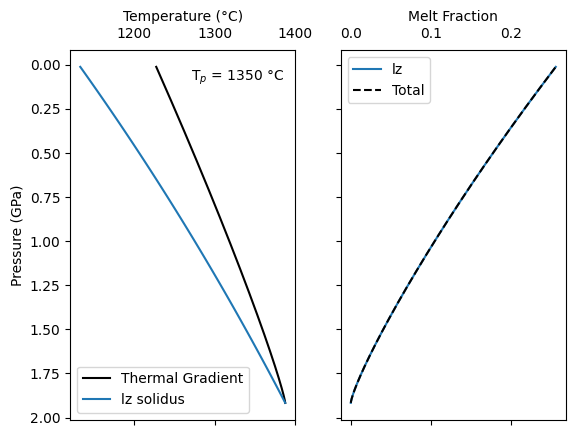

In [6]:
column = mantle.adiabaticMelt(Tp = 1350)
f, a = column.plot()

Try changing the mantle potential temperature in the cell above and see how this varies the maximum melt fraction and the pressure at which melting starts to occur.

While this plot is nice, it doesn't really tell us much other than melting starts around 2 GPa, and reaches a maximum melt extent of ~0.25.

To get information about the thickness of crust produced by mantle melting, and the chemistry of the melts, we have to do a bit more work (sorry)!

To get the crustal thickness, we need to solve the following equation:

$$ t_{c} = \frac{1}{g\rho_{c}} \int_{P_{start}}^{P_{crust}} \frac{\sum{F(P)}}{1 - \sum{F(P)}} dP $$

where $t_c$ is the crustal thickness (in km), $g$ is gravitational acceleration, $\rho_c$ represents the density of basaltic melt (i.e. the density of the crust), $P_{start}$ and $P_{crust}$ represent the pressure at which melting starts and stops (this stop point is solved iteratively as it will be deeper for regions with thicker crust). $F(P)$ is the melt fraction at each pressure in the melt column.

**Luckily for us all, pyMelt can do this calculation for us. All we need to do is tell the code that we are looking at a mid-ocean ridge setting and it will automatically calculate crustal thickness.**

In [7]:
morb = m.geosettings.spreadingCentre(column)
print(round(morb.tc,2), ' km')

6.28  km


But what about the Na content of the basalts that are erupted? Well, pyMelt can calculate that as well.

We need to tell pyMelt the amount of Na that is in the mantle (lets use the value of 0.13 wt%), and the bulk partition coefficient of Na (see lectures for explanation of element partitioning). For the purposes of this calculation, we will assume a partition coefficient of Na between the solid mantle and basaltic melts of 0.05 (i.e., there is ~20 times more Na in the melt than in the mantle residue).

**These are approximate values, taken from the work of Workman and Hart (2005) amongst others. In reality, the partitioning of Na is controlled by pressure, temperature etc.**

In [8]:
Na_mantle = 0.13 # wt%
D_Na = 0.02 #Conc in melt divided by Conc in solid.

# set up a chemistry 'species' for pyMelt - this helps pyMelt 'read' the chemistry of the mantle.
species = m.chemistry.continuousSpecies_instantaneous('Na', Na_mantle, D_Na)

Using this information, pyMelt can now calculate the instantaneous composition of the melt phase formed at each step of the decompression melting model.

### Q1 **What do you notice about the concentration of Na in the melt phase as the depth (pressure) of mantle melting decreases? Can you provide an explanation for this?***

Text(0.5, 0, 'Na$_2$O (wt%)')

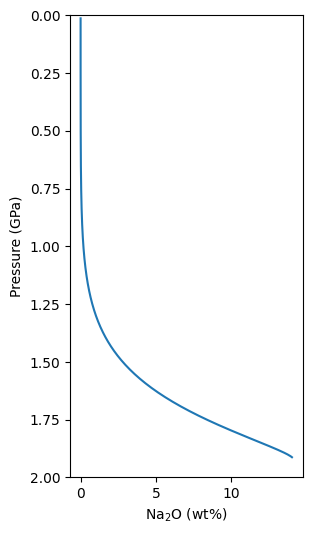

In [9]:
column.calculateChemistry(species_objects = {'lz' :[species]})
f, a = plt.subplots(figsize = (3, 6))
a.plot(61.98*column.lithologies['lz']['Na']/22.99, column.P, '-')
a.set_ylim([2, 0])
a.set_ylabel('Pressure (GPa)')
a.set_xlabel('Na$_2$O (wt%)')

Remember, the composition of the melts in the graph above are the instantaneous melts produced at each depth of the melting region. In reality, we're more likely to consider the composition of the accumulated melt (i.e., all these melts mixed together), as this more accurately represents the composition of erupted basalts. This can be calculated using the code below:

In [10]:
morb = m.geosettings.spreadingCentre(column)
print(round(morb.chemistry['Na'],2), ' wt% Na')

0.94  wt% Na


This is the concentration of Na, but actually we want the concentration of Na$_2$O (we report measurements based on the oxide abundance not the abundance of the pure element). For Na this conversion is relatively easy:

$$ \frac{wt\%\ Na }{22.99}*61.98 = wt\%\ Na_2O $$

In [11]:
print(round(61.98*morb.chemistry['Na']/22.99,2), 'wt% Na$_2$O')

2.54 wt% Na$_2$O


So, if you kept everything as it was as you ran through the code (mantle potential temperature of 1350$^o$C), you should have obtained a Na$_2$O content of 2.54 wt% and a crustal thickness of 6.28 km.

The question is, does this match the graph above (included here as well)?

![alt text](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcR24SagNdaLJDODeiExeCigPj0WBAonRwQSKhcgG88K8t3KY9ko)

To answer that question, we need to consider the principles of isostacy. Read this quick summary: https://opentextbc.ca/geology/chapter/9-4-isostasy/

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Airy_Isostasy.jpg/440px-Airy_Isostasy.jpg)


### Q2 - **Assuming seawater, oceanic crust, and mantle have densities of 1000 kg/m$^3$, 2700 kg/m$^3$, and 3400 kg/m$^3$, convert the results above from crustal thickness to 'axial depth'. Are our results consistent with the graph? Assume a crust 5 km thick would have an axial depth of 4000 m**

To do this, we basically need to consider that the excess mass by adding crust at depths < 4000m (where there was previously water) needs to be balanced by the presence of a crustal 'root' where the crust is less dense by the surrounding mantle. In short (comparing the far left and far right sides of the schematic above):

$$ h_2*(𝜌_c-𝜌_w) = b_2*(𝜌_m-𝜌_c) $$

where $𝜌_{w/c/m}$ represents the density of water, crust, and mantle, respectively. To get the crustal thickness (in metres), you simply calculate:

$$ t_c = 5,000 + h_2 + b_2 $$

Remembering that our 'base' scenario is a 5 km thick crust. The axial depth of this crust, again in metres, is:

$$ Axial\ Depth = 4,000 - h_2 $$

### Q3 - **Now that we've done this calculation for one example, let's see if we can recreate that entire graph! Using the method below, create graphs of (i) crustal thickness vs Na$_2$O content (at 8 wt% MgO); and (ii) axial depth vs Na$_2$O content at 8 wt% MgO. How do the results of your models compare to the graph of Na2O vs axial depth? Write a brief explanation as to why these two variables are correlated in natural systems.**

In [22]:
## READ CAREFULLY BEFORE RUNNING $ this cell will take about a minute to complete.
# first let's define a general mantle as above
lz = m.lithologies.matthews.klb1()
mantle = m.mantle([lz], [1], ['lz'])

# set up Na chemistry again
Na_mantle = 0.13 # wt%
D_Na = 0.02 #Conc in melt divided by Conc in solid.

# set up a chemistry 'species' for pyMelt - this helps pyMelt 'read' the chemistry of the mantle.
species = m.chemistry.continuousSpecies_instantaneous('Na', Na_mantle, D_Na)

# set the density of the different components
pw = 1000 # kg/m3
pc = 2700 # kg/m3
pm = 3400 # kg/m3

# now, rather than doing just one calculation, we can 'loop' through temperature
## You'll need to fill in the missing bits of code to complete this. The missing parts are highlighted

# first we need to set up our inputs and create some variables to 'fill'
Tp = np.linspace(1250,    ,50) # Mantle potential temperature (min, max, n). Fill in the middle value (i.e., max Tp) - this code sets an array of numbers from min to max, n times (values 1, 2, and 3 in the parentheses)
tc = np.zeros(len(Tp)) # Crustal thickness variable - currently zero, but will fill it later. Same length (number of values) as Tp
Na2O = np.zeros(len(Tp)) # Sodium Oxide (make sure you notice it's the oxide and apply the necessary conversion) variable. Same length (number of values) as Tp
AD = np.zeros(len(Tp)) # Axial Depth variable (to fill) same length as Tp.

# Do the loop
for i in range(len(Tp)):
  column = mantle.adiabaticMelt(Tp = Tp[i])
  column.calculateChemistry(species_objects = {'lz' :[species]})
  morb = m.geosettings.spreadingCentre(column) # this will now do crustal thickness and Na calculations

  # extract crustal thickness information
  tc[i] =  # Look at the code above to find out what you need here. Note that pyMelt automatically returns this in units of km

  # Extract the Na content - and convert to Na2O
  Na = morb.chemistry['Na']
  Na2O[i] =  # Look at the notes above to work out how to do the conversion.

  h2 = (tc[i]*1000-5000)/(1+(pc-pw)/(pm-pc)) # convert crustal thickness into axial depth
  AD[i] = 4000-h2



In [24]:
# create a two by one plot
f, a = plt.subplots(1,2, sharey=True)
f.tight_layout()

# label to axes
a[0].set_ylabel('Na$_2$O (wt%)')
a[0].set_xlabel('Crustal Thickness (km)')
a[1].set_xlabel('Axial Depth (m)')

# plot your model results
a[0].plot(tc,Na2O, 'ok')

a[1].plot(AD, Na2O, 'ok')